In [28]:
import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.float_format', '{:.2f}'.format)

# 
import numpy, scipy, statsmodels, matplotlib
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats




df = pd.read_csv("case_study_preprocessing_issue_id.csv")
df_touchpoint = pd.read_csv("case_study_preprocessing_touchpoint_id.csv")



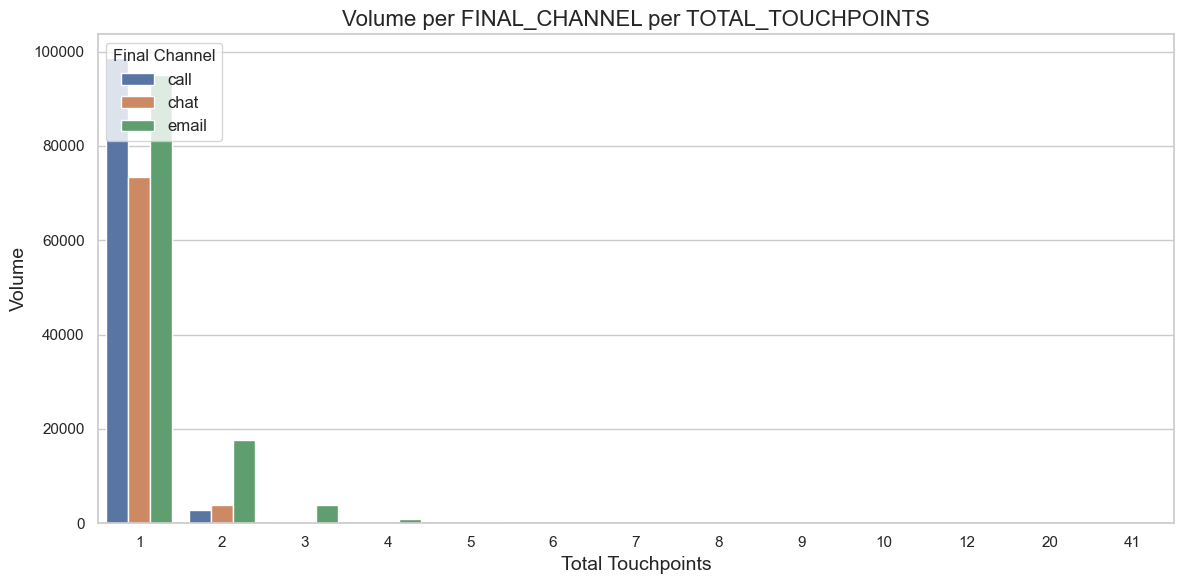

In [22]:
# plot volumes to understand number of touch points better 

volume_data = df.groupby(['FINAL_CHANNEL', 'TOTAL_TOUCHPOINTS']).size().reset_index(name='VOLUME')
# Set the aesthetics for the plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
sns.barplot(data=volume_data, x='TOTAL_TOUCHPOINTS', y='VOLUME', hue='FINAL_CHANNEL', dodge=True)

# Customize the chart
plt.title('Volume per FINAL_CHANNEL per TOTAL_TOUCHPOINTS', fontsize=16)
plt.xlabel('Total Touchpoints', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-ticks for better visibility
plt.legend(title='Final Channel', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# here we can see that the majority of issues are solved with a single contact point 
# the majority of issues taking more than one contact are email or mixed 
# email is a channel that is expected to have higher number of contact points as it deals with more complex 
# technical issues 
# Would also allow more than 1 contact point for mixed channels, as could need to switch to get solved 


# drop anything above that when figuring out what the new proposed resolution time should be
# chat and call should only be allowed 1 touchpoint as with the low handling times, including a second touchpoint
# can greatly effect the resolution times 

In [23]:
# Filter for TOTAL_TOUCHPOINTS greater than 3 and sum the corresponding VOLUME
total_volume_above_3 = volume_data[volume_data['TOTAL_TOUCHPOINTS'] > 3]['VOLUME'].sum()/volume_data['VOLUME'].sum()*100
total_volume_above_3


0.47745465190224795

In [24]:
# Filter for TOTAL_TOUCHPOINTS greater than 3 and sum the corresponding VOLUME
total_volume_above_2 = volume_data[volume_data['TOTAL_TOUCHPOINTS'] > 2]['VOLUME'].sum()/volume_data['VOLUME'].sum()*100
total_volume_above_2

1.910155080231897

In [25]:
# Filter for TOTAL_TOUCHPOINTS greater than 3 and sum the corresponding VOLUME
total_volume_above_1 = volume_data[volume_data['TOTAL_TOUCHPOINTS'] > 1]['VOLUME'].sum()/volume_data['VOLUME'].sum()*100
total_volume_above_1


10.097543413380171

In [26]:
total_volume_above_1 = volume_data[
    (volume_data['TOTAL_TOUCHPOINTS'] > 1) &
    (volume_data['FINAL_CHANNEL'].isin(['call', 'chat']))
]['VOLUME'].sum() / volume_data['VOLUME'].sum() * 100

total_volume_above_1

2.3818896975447594

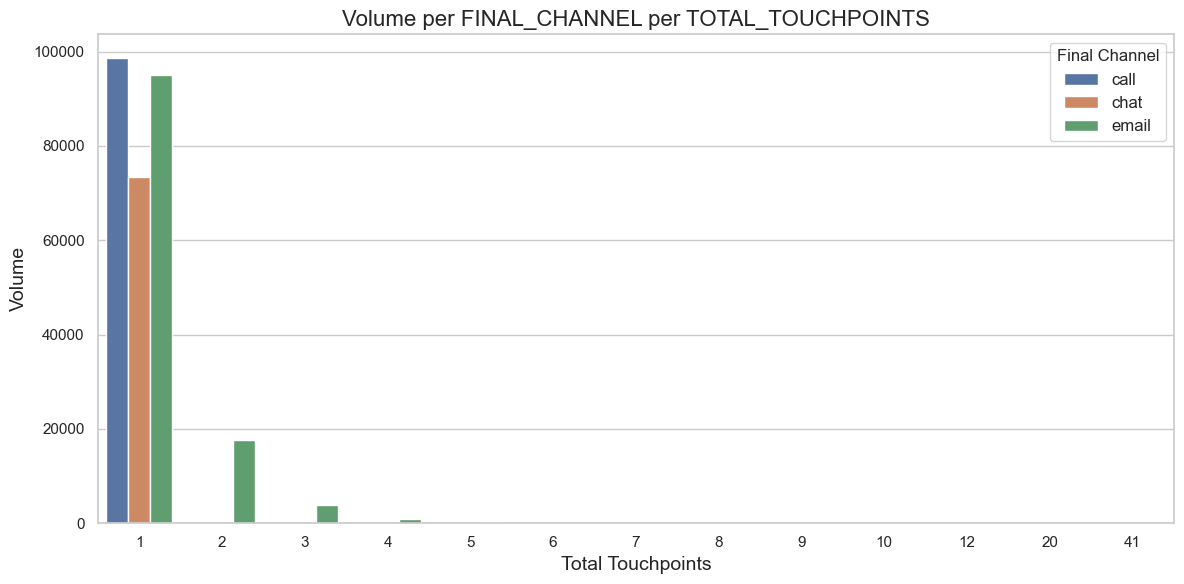

In [27]:
df = df[~((df['FINAL_CHANNEL'].isin(['chat', 'call'])) & (df['TOTAL_TOUCHPOINTS'] > 1))]
#remove call and chat that have more than 1 touch point as this will heavily skew response times - also accounts 
# for low volumes

volume_data = df.groupby(['FINAL_CHANNEL', 'TOTAL_TOUCHPOINTS']).size().reset_index(name='VOLUME')
# Set the aesthetics for the plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Create the bar plot
sns.barplot(data=volume_data, x='TOTAL_TOUCHPOINTS', y='VOLUME', hue='FINAL_CHANNEL', dodge=True)

# Customize the chart
plt.title('Volume per FINAL_CHANNEL per TOTAL_TOUCHPOINTS', fontsize=16)
plt.xlabel('Total Touchpoints', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=0)  # Rotate x-ticks for better visibility
plt.legend(title='Final Channel', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# here we can see that the majority of issues are solved with a single contact point 
# the majority of issues taking more than one contact are email
# email is a channel that is expected to have higher number of contact points as it deals with more complex 
# technical issues 

# drop anything above that when figuring out what the new proposed resolution time should be
# chat and call should only be allowed 1 touchpoint as with the low handling times, including a second touchpoint
# can greatly effect the resolution times 


In [69]:

total_volume = df['TOTAL_RESOLUTION_TIME_SECONDS'].count()  # Total count of interactions

# Step 2: Group by 'FINAL_CHANNEL' and aggregate
percentiles_channel_touchpoints = df.groupby(['FINAL_CHANNEL']).agg(
    VOLUME_PERCENTAGE=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: (len(x) / total_volume) * 100),  # Percentage of total interactions
    Q75_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.75)),
    Q80_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.80)),
    Q90_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.90)),
    Q75_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.75)),
    Q80_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.80)),
    Q90_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.90))
).reset_index()

# Display the results
percentiles_channel_touchpoints
      

,FINAL_CHANNEL,VOLUME_PERCENTAGE,Q75_MINUTES,Q80_MINUTES,Q90_MINUTES,Q75_DAYS,Q80_DAYS,Q90_DAYS
0,call,34.03,15.82,17.45,22.58,0.01,0.01,0.02
1,chat,25.32,19.10,21.12,27.35,0.01,0.01,0.02
2,email,40.65,2578.98,3353.22,6887.96,1.79,2.33,4.78


In [70]:
percentiles_channel_touchpoints = df.groupby(['FINAL_CHANNEL', 'PRIORITY']).agg(
    VOLUME_PERCENTAGE=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: (len(x) / total_volume) * 100),  # Percentage of total interactions
    Q75_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.75)),
    Q80_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.80)),
    Q90_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.90)),
    Q75_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.75)),
    Q80_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.80)),
    Q90_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.90)),
    
    # Adding percentiles for QUEUE_WAITING_TIME_SECONDS
    Q75_QUEUE_WAITING_SECONDS=('QUEUE_WAITING_TIME_SECONDS', lambda x: x.quantile(0.75)),
    Q80_QUEUE_WAITING_SECONDS=('QUEUE_WAITING_TIME_SECONDS', lambda x: x.quantile(0.80)),
    Q90_QUEUE_WAITING_SECONDS=('QUEUE_WAITING_TIME_SECONDS', lambda x: x.quantile(0.90))
).reset_index()

# Display the results
percentiles_channel_touchpoints


,FINAL_CHANNEL,PRIORITY,VOLUME_PERCENTAGE,Q75_MINUTES,Q80_MINUTES,Q90_MINUTES,Q75_DAYS,Q80_DAYS,Q90_DAYS,Q75_QUEUE_WAITING_SECONDS,Q80_QUEUE_WAITING_SECONDS,Q90_QUEUE_WAITING_SECONDS
0,call,1,2.62,16.07,17.42,21.72,0.01,0.01,0.02,19.00,24.00,71.00
1,call,2,17.06,15.47,17.10,22.20,0.01,0.01,0.02,18.00,22.00,60.00
2,call,3,14.35,16.18,17.83,23.18,0.01,0.01,0.02,18.00,21.00,52.00
3,chat,1,3.35,21.83,23.90,30.32,0.02,0.02,0.02,3.00,3.00,34.30
4,chat,2,10.87,18.50,20.35,26.48,0.01,0.01,0.02,3.00,3.00,27.00
5,chat,3,11.10,18.75,20.90,27.13,0.01,0.01,0.02,3.00,3.00,15.00
6,email,1,1.59,1917.95,2663.76,5267.14,1.33,1.85,3.66,0.00,0.00,0.00
7,email,2,21.00,2477.92,3068.10,6407.09,1.72,2.13,4.45,0.00,0.00,0.00
8,email,3,18.06,2737.71,3882.38,7202.85,1.90,2.70,5.00,0.00,0.00,0.00


In [71]:
percentiles_channel_touchpoints = df.groupby(['FINAL_CHANNEL', 'COUNTRY']).agg(
    VOLUME_PERCENTAGE=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: (len(x) / total_volume) * 100),  # Percentage of total interactions
    Q90_MINUTES=('TOTAL_RESOLUTION_TIME_MINUTES', lambda x: x.quantile(0.90)),
    Q90_DAYS=('TOTAL_RESOLUTION_TIME_DAYS', lambda x: x.quantile(0.90)),
    
    # Adding percentiles for QUEUE_WAITING_TIME_SECONDS
    Q90_QUEUE_WAITING_SECONDS=('QUEUE_WAITING_TIME_SECONDS', lambda x: x.quantile(0.90))
).reset_index()

# Display the results
percentiles_channel_touchpoints

,FINAL_CHANNEL,COUNTRY,VOLUME_PERCENTAGE,Q90_MINUTES,Q90_DAYS,Q90_QUEUE_WAITING_SECONDS
0,call,FR,14.98,21.08,0.01,38.00
1,call,IT,19.05,23.67,0.02,85.00
2,chat,FR,11.71,28.62,0.02,19.00
3,chat,IT,13.61,26.27,0.02,25.00
4,email,FR,23.34,8224.32,5.71,0.00
5,email,IT,17.31,5006.52,3.48,0.00


In [29]:
df_touchpoint.head()

,TOUCHPOINT_ID,REASON,DETAILED_REASON,REASON_GROUP,COUNTRY,CHANNEL,STATUS,MERCHANT_ID,MCC_GROUP,TOTAL_HANDLING_TIME_SECONDS,RESPONSE_TIME_SECONDS,QUEUE_WAITING_TIME_SECONDS,AGENT_ID,AGENT_COMPANY,CREATED_AT,ENDED_AT,ISSUE_ID,MIN_CREATED_AT,MAX_ENDED_AT,FINAL_STATUS,TOTAL_TOUCHPOINTS,TOTAL_RESOLUTION_TIME_SECONDS,TOTAL_RESOLUTION_TIME_MINUTES,TOTAL_RESOLUTION_TIME_DAYS,FINAL_CHANNEL,PRIORITY
0,-4734646118033616665,Solo,Solo: Blocked,Blocked/defective readers,FR,chat,Serviced,-9223326802583772234,Miscellaneous Stores,686.00,1.00,1.00,3613549400291781931,BPO1,2022-10-05 11:22:58+00:00,2022-10-05 11:34:25+00:00,1,2022-10-05 11:22:58+00:00,2022-10-05 11:34:25+00:00,Serviced,1,687.00,11.45,0.01,chat,1
1,-202575608778639817,Outage,Outage,Outage,IT,call,Resolved,-9223313154224916571,Retail Outlet Services,250.00,42.00,42.00,3109154870074365133,BPO1,2022-03-01 17:21:24+00:00,2022-03-01 17:26:16+00:00,2,2022-03-01 17:21:24+00:00,2022-03-01 17:26:16+00:00,Resolved,1,292.00,4.87,0.00,call,1
2,2807329782670046316,SUP - Profile,SUP: Change phone number,Changing account details,FR,email,Resolved,-9223285525841990369,Miscellaneous Stores,0.00,274.00,0.00,8817975702393619368,BPO1,2022-08-05 17:31:00+00:00,2022-08-05 17:35:34+00:00,3,2022-08-05 17:31:00+00:00,2022-08-05 17:35:34+00:00,Resolved,1,274.00,4.57,0.00,email,3
3,-9113123566195022652,Business Accounts,BA: Transfer Issue - Outgoing Transfer,Other technical issues,FR,chat,Resolved,-9223254334486076891,Retail Outlet Services,743.00,3.00,3.00,-8620601645774088329,BPO1,2022-11-28 17:51:59+00:00,2022-11-28 18:04:25+00:00,4,2022-11-28 17:51:59+00:00,2022-11-28 18:04:25+00:00,Resolved,1,746.00,12.43,0.01,chat,2
4,4894649142308777422,Pre SignUp - SignUp,No activation code,Signup,IT,call,Resolved,-9223210546642890192,Miscellaneous Stores,684.00,10.00,10.00,-2139152697461735578,BPO1,2022-03-29 19:42:56+00:00,2022-03-29 19:54:30+00:00,5,2022-03-29 19:42:56+00:00,2022-03-29 19:54:30+00:00,Resolved,1,694.00,11.57,0.01,call,3


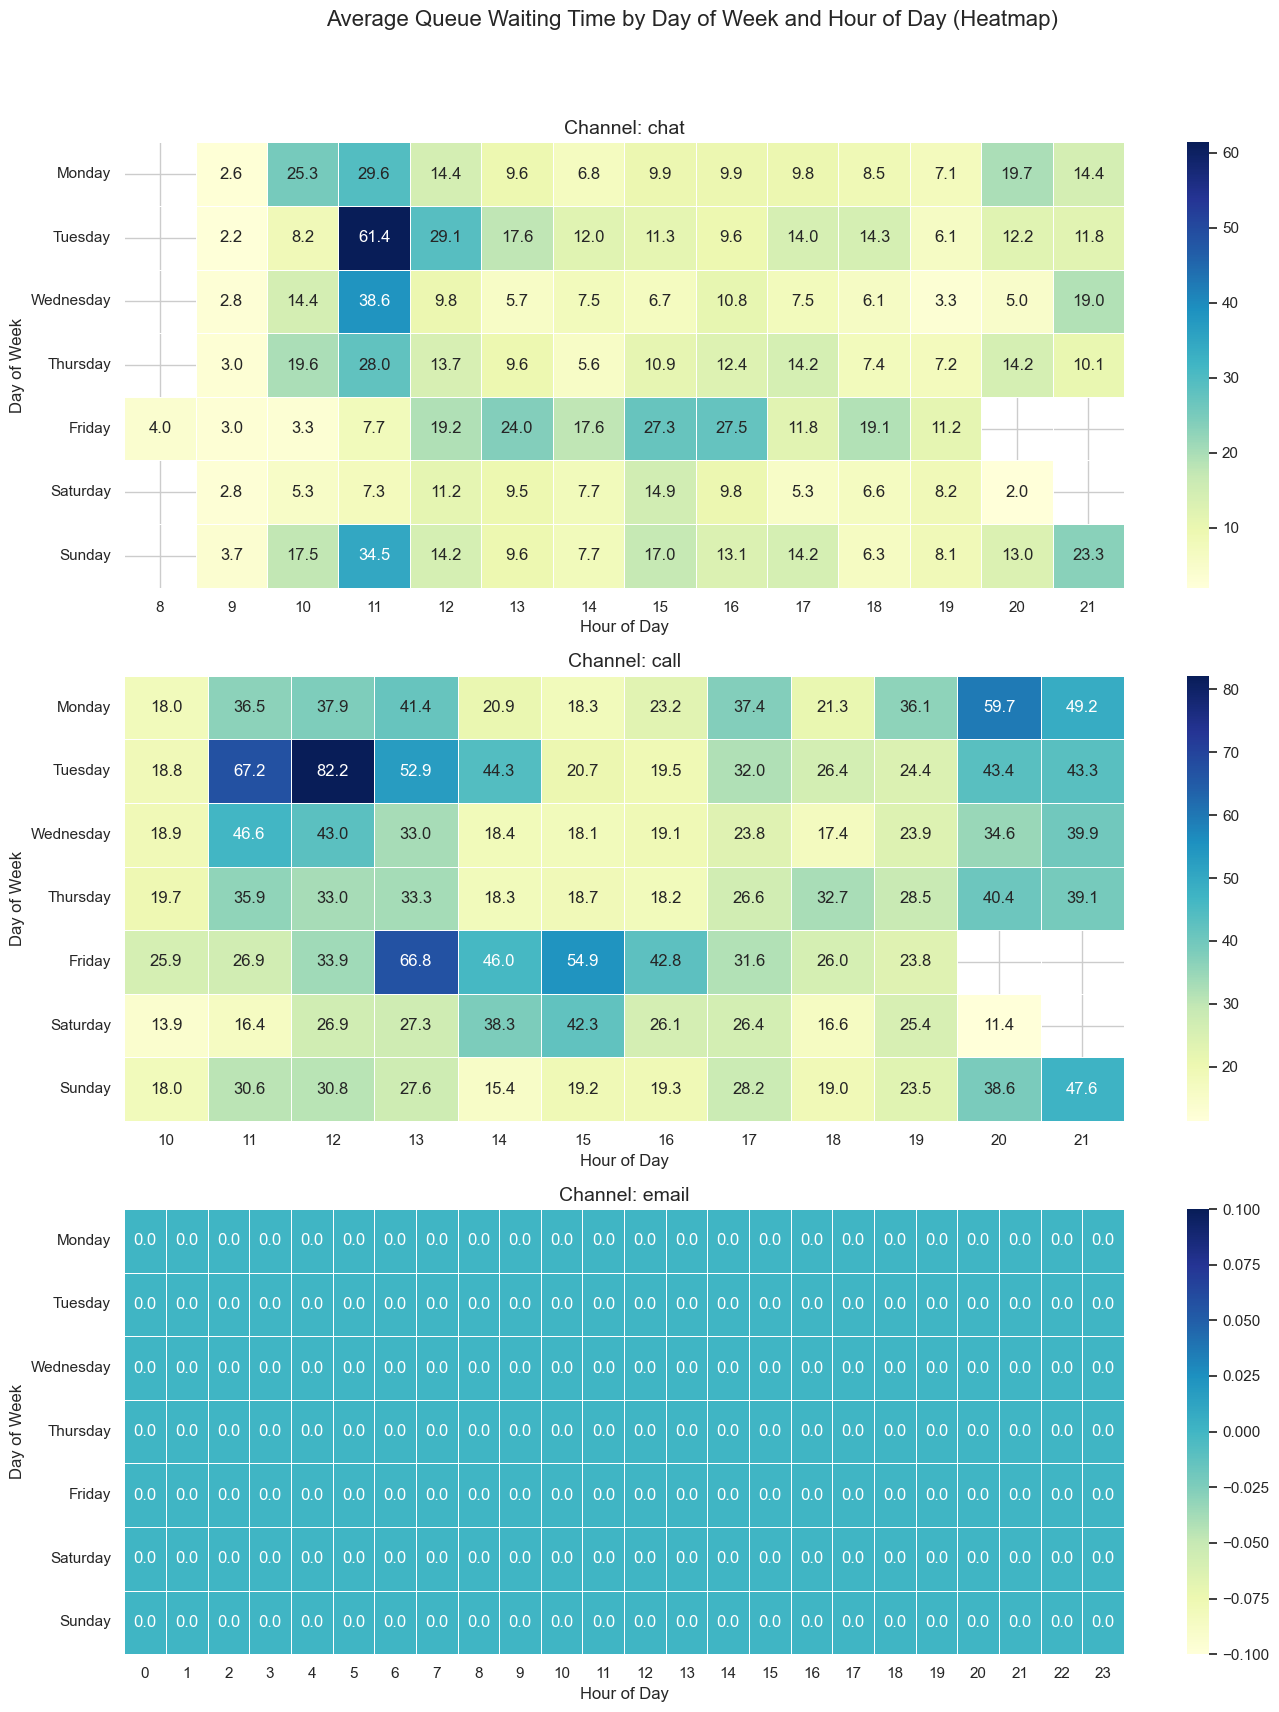

In [32]:


# Ensure 'CREATED_AT' is timezone aware and convert to CET
df_touchpoint['CREATED_AT'] = pd.to_datetime(df_touchpoint['CREATED_AT'], errors='coerce').dt.tz_convert('CET')

# Extract hour and day of week
df_touchpoint['CREATED_AT_HOUR'] = df_touchpoint['CREATED_AT'].dt.hour
df_touchpoint['CREATED_AT_DAY_OF_WEEK'] = df_touchpoint['CREATED_AT'].dt.day_name()

# Ensure 'CREATED_AT_DAY_OF_WEEK' follows the correct order (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_touchpoint['CREATED_AT_DAY_OF_WEEK'] = pd.Categorical(df_touchpoint['CREATED_AT_DAY_OF_WEEK'], categories=day_order, ordered=True)

# Fill NaN in 'QUEUE_WAITING_TIME_SECONDS' with 0 to avoid errors
df_touchpoint['QUEUE_WAITING_TIME_SECONDS'].fillna(0, inplace=True)

# Group data by hour, day of week, and channel, then calculate mean queue waiting time
avg_queue_time = df_touchpoint.groupby(['CREATED_AT_DAY_OF_WEEK', 'CREATED_AT_HOUR', 'CHANNEL'])['QUEUE_WAITING_TIME_SECONDS'].mean().reset_index()

# Pivot the data for heatmap (day of week as rows, hour of day as columns)
heatmap_data = avg_queue_time.pivot_table(index='CREATED_AT_DAY_OF_WEEK', columns='CREATED_AT_HOUR', values='QUEUE_WAITING_TIME_SECONDS')

# Get the list of unique channels
channels = df_touchpoint['CHANNEL'].unique()

# Create subplots for each channel's heatmap
fig, axes = plt.subplots(len(channels), 1, figsize=(14, len(channels) * 6))  # Adjusting figure size based on number of channels
fig.suptitle('Average Queue Waiting Time by Day of Week and Hour of Day (Heatmap)', fontsize=16)

# Plot heatmap for each channel
for i, channel in enumerate(channels):
    # Filter data for the specific channel
    channel_data = avg_queue_time[avg_queue_time['CHANNEL'] == channel]
    
    # Pivot the data for heatmap
    heatmap_data = channel_data.pivot_table(index='CREATED_AT_DAY_OF_WEEK', columns='CREATED_AT_HOUR', values='QUEUE_WAITING_TIME_SECONDS')

    # Plot the heatmap
    sns.heatmap(heatmap_data, ax=axes[i], cmap='YlGnBu', annot=True, fmt='.1f', linewidths=.5)
    
    # Set the title and labels
    axes[i].set_title(f'Channel: {channel}', fontsize=14)
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Day of Week')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


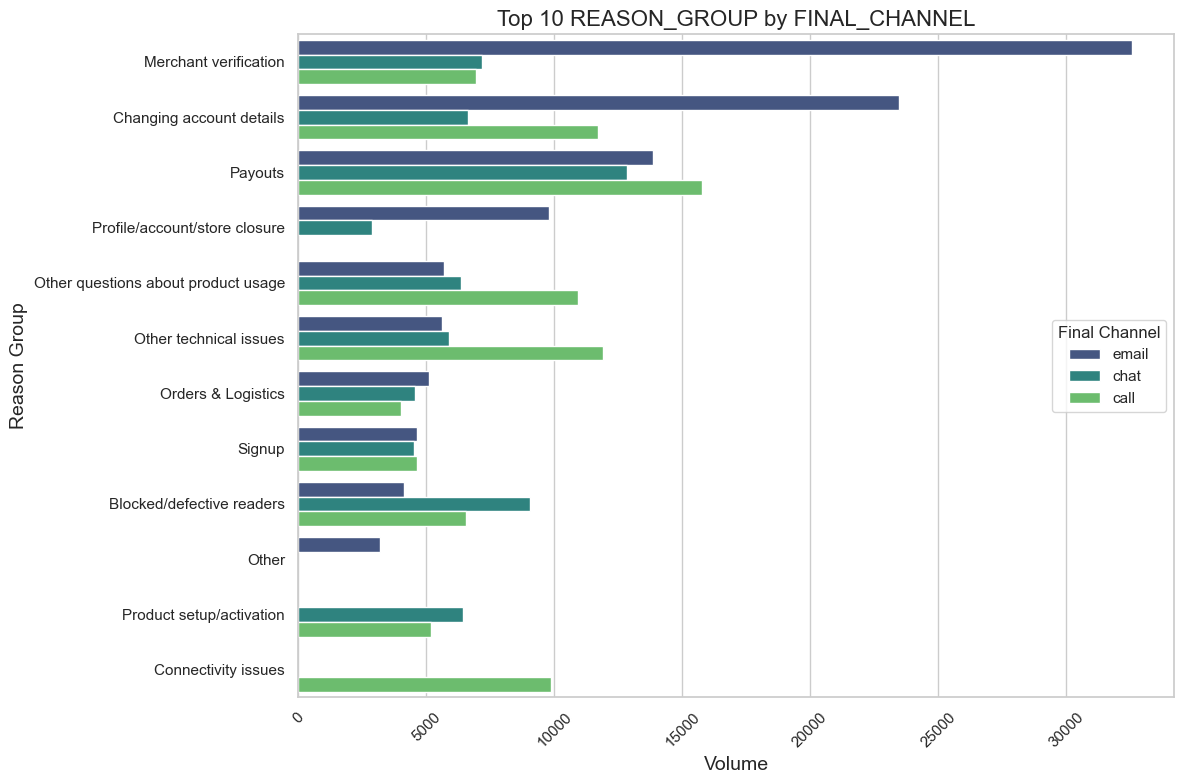

In [72]:
# Step 1: Group by FINAL_CHANNEL and REASON_GROUP to get volumes
volume_df = df.groupby(['FINAL_CHANNEL', 'REASON_GROUP']).size().reset_index(name='VOLUME')

# Step 2: Get the top 10 REASON_GROUP for each FINAL_CHANNEL
top_reasons = volume_df.sort_values(['FINAL_CHANNEL', 'VOLUME'], ascending=False)\
                        .groupby('FINAL_CHANNEL')\
                        .head(10)

# Step 3: Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=top_reasons, x='VOLUME', y='REASON_GROUP', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the chart
plt.title('Top 10 REASON_GROUP by FINAL_CHANNEL', fontsize=16)
plt.xlabel('Volume', fontsize=14)
plt.ylabel('Reason Group', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the plot
plt.show()

In [73]:


total_volume = volume_df['VOLUME'].sum()
top_reasons_volume = top_reasons['VOLUME'].sum()
percentage_accounted_for = (top_reasons_volume / total_volume) * 100

# Print the results
print(f'Total Volume: {total_volume}')
print(f'Top 10 Volume: {top_reasons_volume}')
print(f'Percentage of Total Volume Accounted For by Top 10: {percentage_accounted_for:.2f}%')


Total Volume: 290122
Top 10 Volume: 262063
Percentage of Total Volume Accounted For by Top 10: 90.33%


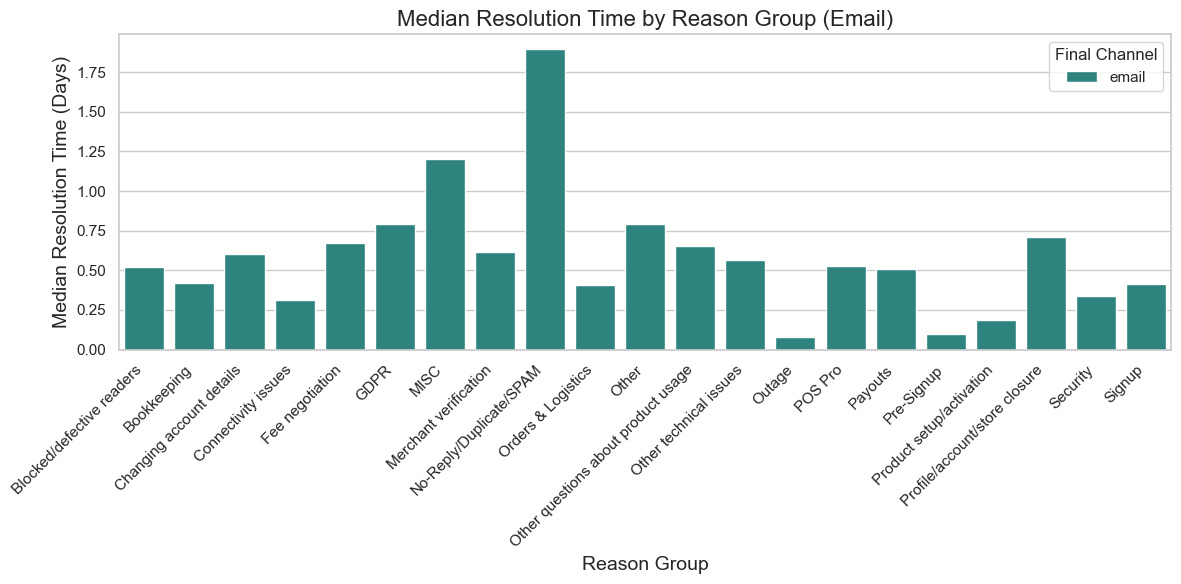

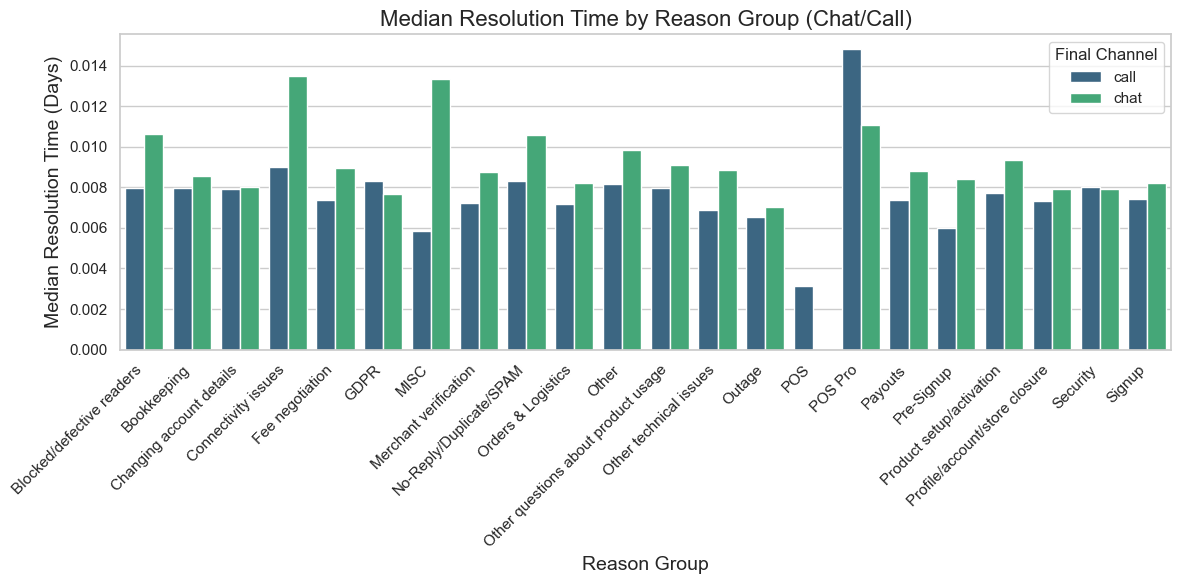

In [74]:


# Set the style for seaborn
sns.set(style="whitegrid")

# Filter for FINAL_CHANNEL = mixed or email
mixed_email_df = df[df['FINAL_CHANNEL'].isin(['mixed', 'email'])]

# Group by REASON_GROUP and calculate the median resolution time for mixed/email
avg_resolution_time_mixed_email = (mixed_email_df.groupby(['REASON_GROUP', 'FINAL_CHANNEL'])['TOTAL_RESOLUTION_TIME_DAYS']
                                    .median()
                                    .reset_index())

# Create the first bar plot for mixed and email
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_resolution_time_mixed_email, x='REASON_GROUP', y='TOTAL_RESOLUTION_TIME_DAYS', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the first chart
plt.title('Median Resolution Time by Reason Group (Email)', fontsize=16)
plt.xlabel('Reason Group', fontsize=14)
plt.ylabel('Median Resolution Time (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the first plot
plt.show()

# Filter for FINAL_CHANNEL = chat or call
chat_call_df = df[df['FINAL_CHANNEL'].isin(['chat', 'call'])]

# Group by REASON_GROUP and calculate the median resolution time for chat/call
avg_resolution_time_chat_call = (chat_call_df.groupby(['REASON_GROUP', 'FINAL_CHANNEL'])['TOTAL_RESOLUTION_TIME_DAYS']
                                  .median()
                                  .reset_index())

# Create the second bar plot for chat and call
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_resolution_time_chat_call, x='REASON_GROUP', y='TOTAL_RESOLUTION_TIME_DAYS', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the second chart
plt.title('Median Resolution Time by Reason Group (Chat/Call)', fontsize=16)
plt.xlabel('Reason Group', fontsize=14)
plt.ylabel('Median Resolution Time (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the second plot
plt.show()


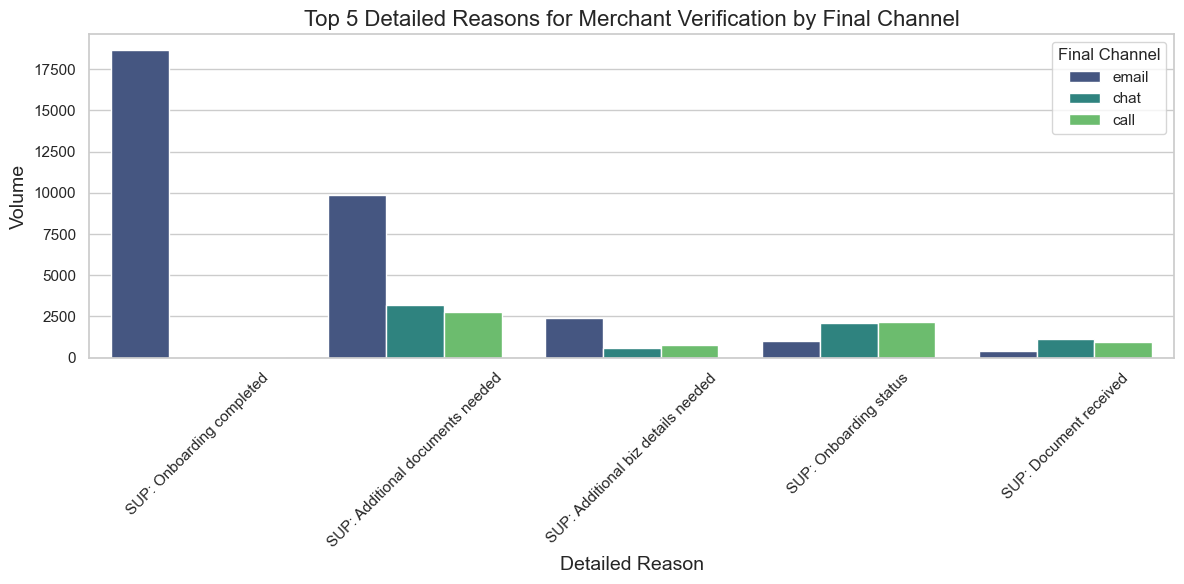

In [75]:
# Filter the DataFrame for 'Merchant verification' in REASON_GROUP
merchant_verification_df = df[df['REASON_GROUP'] == 'Merchant verification']

# Count the occurrences of each DETAILED_REASON split by FINAL_CHANNEL
reason_counts = (merchant_verification_df.groupby(['FINAL_CHANNEL', 'DETAILED_REASON'])
                 .size()
                 .reset_index(name='VOLUME'))

# Get the top 5 DETAILED_REASON for each FINAL_CHANNEL
top_reasons = reason_counts.sort_values(['FINAL_CHANNEL', 'VOLUME'], ascending=False) \
                           .groupby('FINAL_CHANNEL') \
                           .head(5)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_reasons, x='DETAILED_REASON', y='VOLUME', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the chart
plt.title('Top 5 Detailed Reasons for Merchant Verification by Final Channel', fontsize=16)
plt.xlabel('Detailed Reason', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the plot
plt.show()


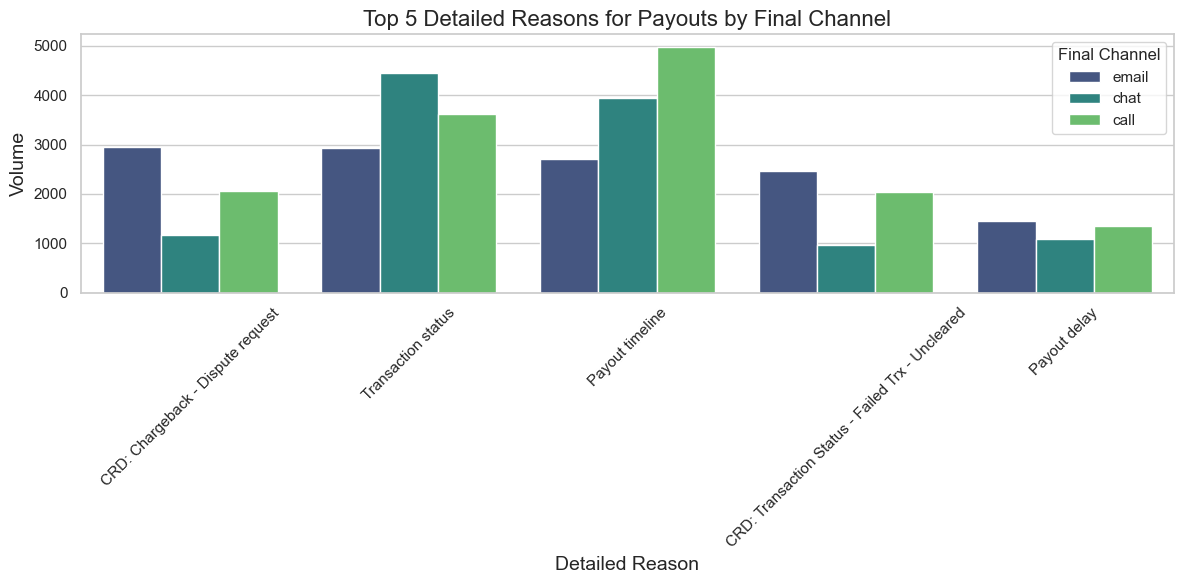

In [77]:
# Filter the DataFrame for 'Merchant verification' in REASON_GROUP
merchant_verification_df = df[df['REASON_GROUP'] == 'Payouts']

# Count the occurrences of each DETAILED_REASON split by FINAL_CHANNEL
reason_counts = (merchant_verification_df.groupby(['FINAL_CHANNEL', 'DETAILED_REASON'])
                 .size()
                 .reset_index(name='VOLUME'))

# Get the top 5 DETAILED_REASON for each FINAL_CHANNEL
top_reasons = reason_counts.sort_values(['FINAL_CHANNEL', 'VOLUME'], ascending=False) \
                           .groupby('FINAL_CHANNEL') \
                           .head(5)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_reasons, x='DETAILED_REASON', y='VOLUME', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the chart
plt.title('Top 5 Detailed Reasons for Payouts by Final Channel', fontsize=16)
plt.xlabel('Detailed Reason', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the plot
plt.show()

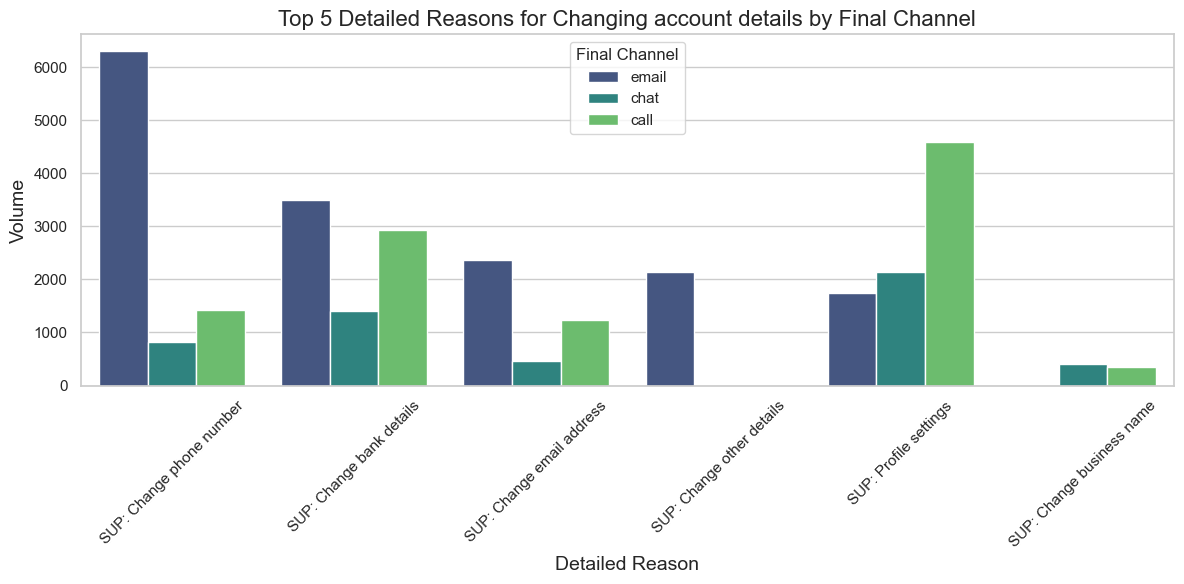

In [78]:
# Filter the DataFrame for 'Merchant verification' in REASON_GROUP
merchant_verification_df = df[df['REASON_GROUP'] == 'Changing account details']

# Count the occurrences of each DETAILED_REASON split by FINAL_CHANNEL
reason_counts = (merchant_verification_df.groupby(['FINAL_CHANNEL', 'DETAILED_REASON'])
                 .size()
                 .reset_index(name='VOLUME'))

# Get the top 5 DETAILED_REASON for each FINAL_CHANNEL
top_reasons = reason_counts.sort_values(['FINAL_CHANNEL', 'VOLUME'], ascending=False) \
                           .groupby('FINAL_CHANNEL') \
                           .head(5)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_reasons, x='DETAILED_REASON', y='VOLUME', hue='FINAL_CHANNEL', palette='viridis')

# Customizing the chart
plt.title('Top 5 Detailed Reasons for Changing account details by Final Channel', fontsize=16)
plt.xlabel('Detailed Reason', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Final Channel')
plt.tight_layout()

# Show the plot
plt.show()

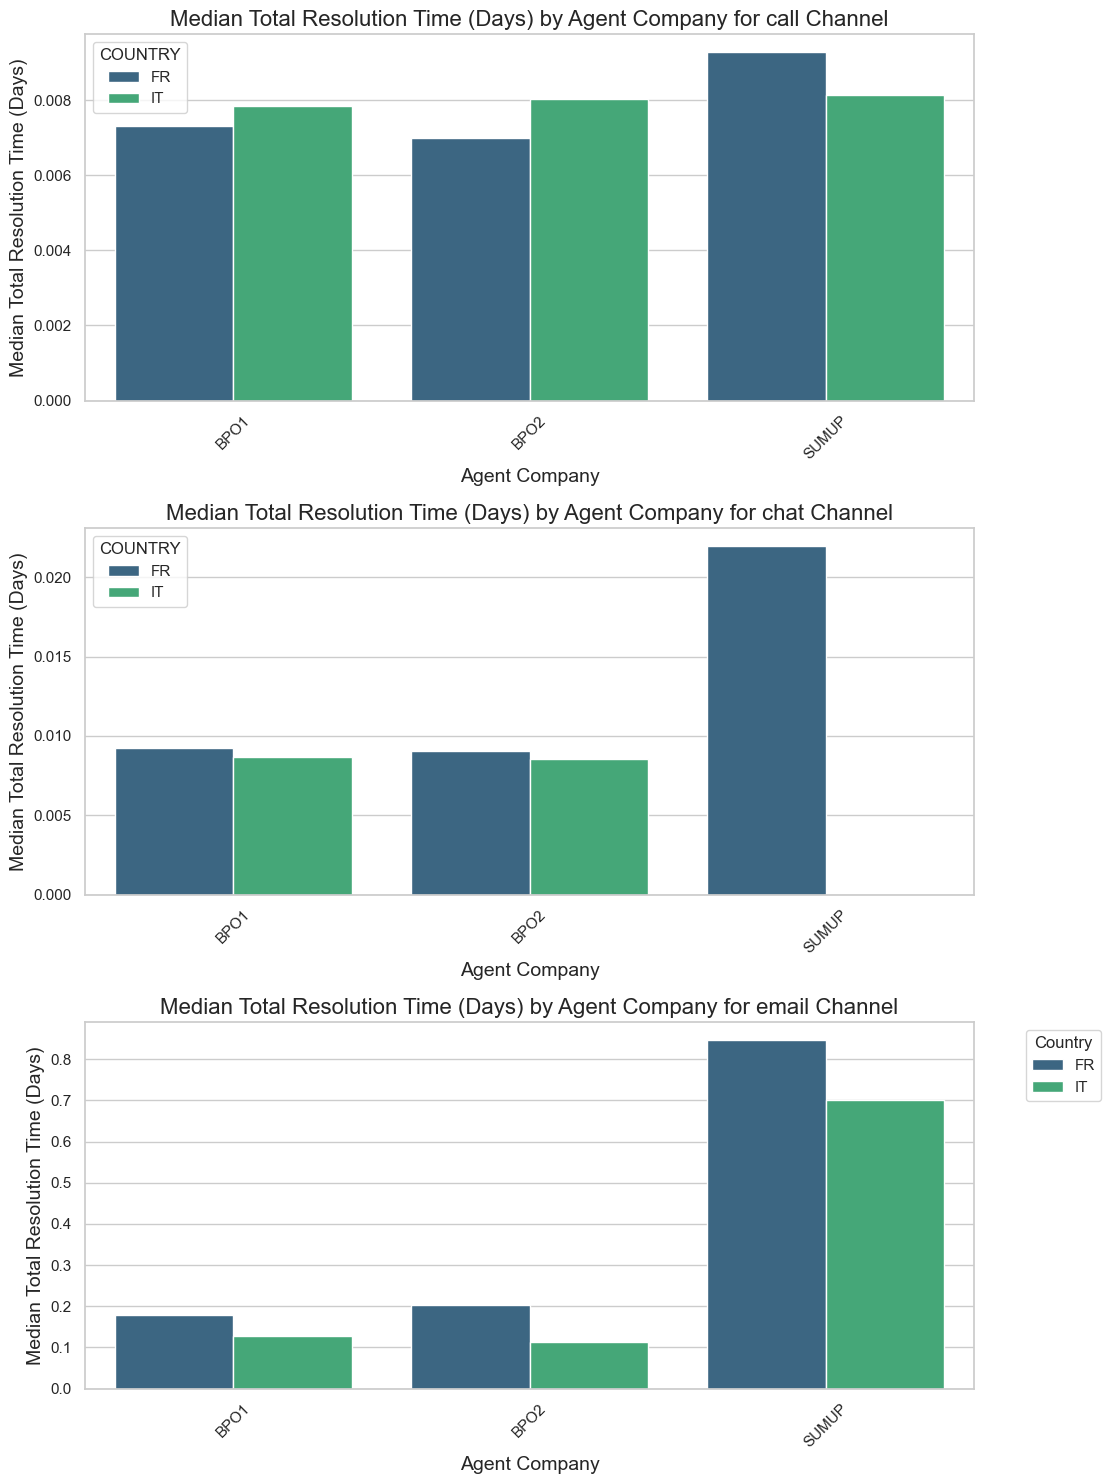

In [83]:
median_resolution_time = df.groupby(['AGENT_COMPANY', 'FINAL_CHANNEL', 'COUNTRY'])['TOTAL_RESOLUTION_TIME_DAYS'].median().reset_index()

# Set up the plotting area
unique_channels = median_resolution_time['FINAL_CHANNEL'].unique()
num_channels = len(unique_channels)

# Create subplots for each channel
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels), sharex=False)

# Loop through each unique channel and create a separate bar plot
for ax, channel in zip(axes, unique_channels):
    # Filter data for the current channel
    channel_data = median_resolution_time[median_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create the bar plot for the current channel
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', hue='COUNTRY', ax=ax, palette='viridis')
    
    # Set titles and labels
    ax.set_title(f'Median Total Resolution Time (Days) by Agent Company for {channel} Channel', fontsize=16)
    ax.set_ylabel('Median Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plots
plt.show()

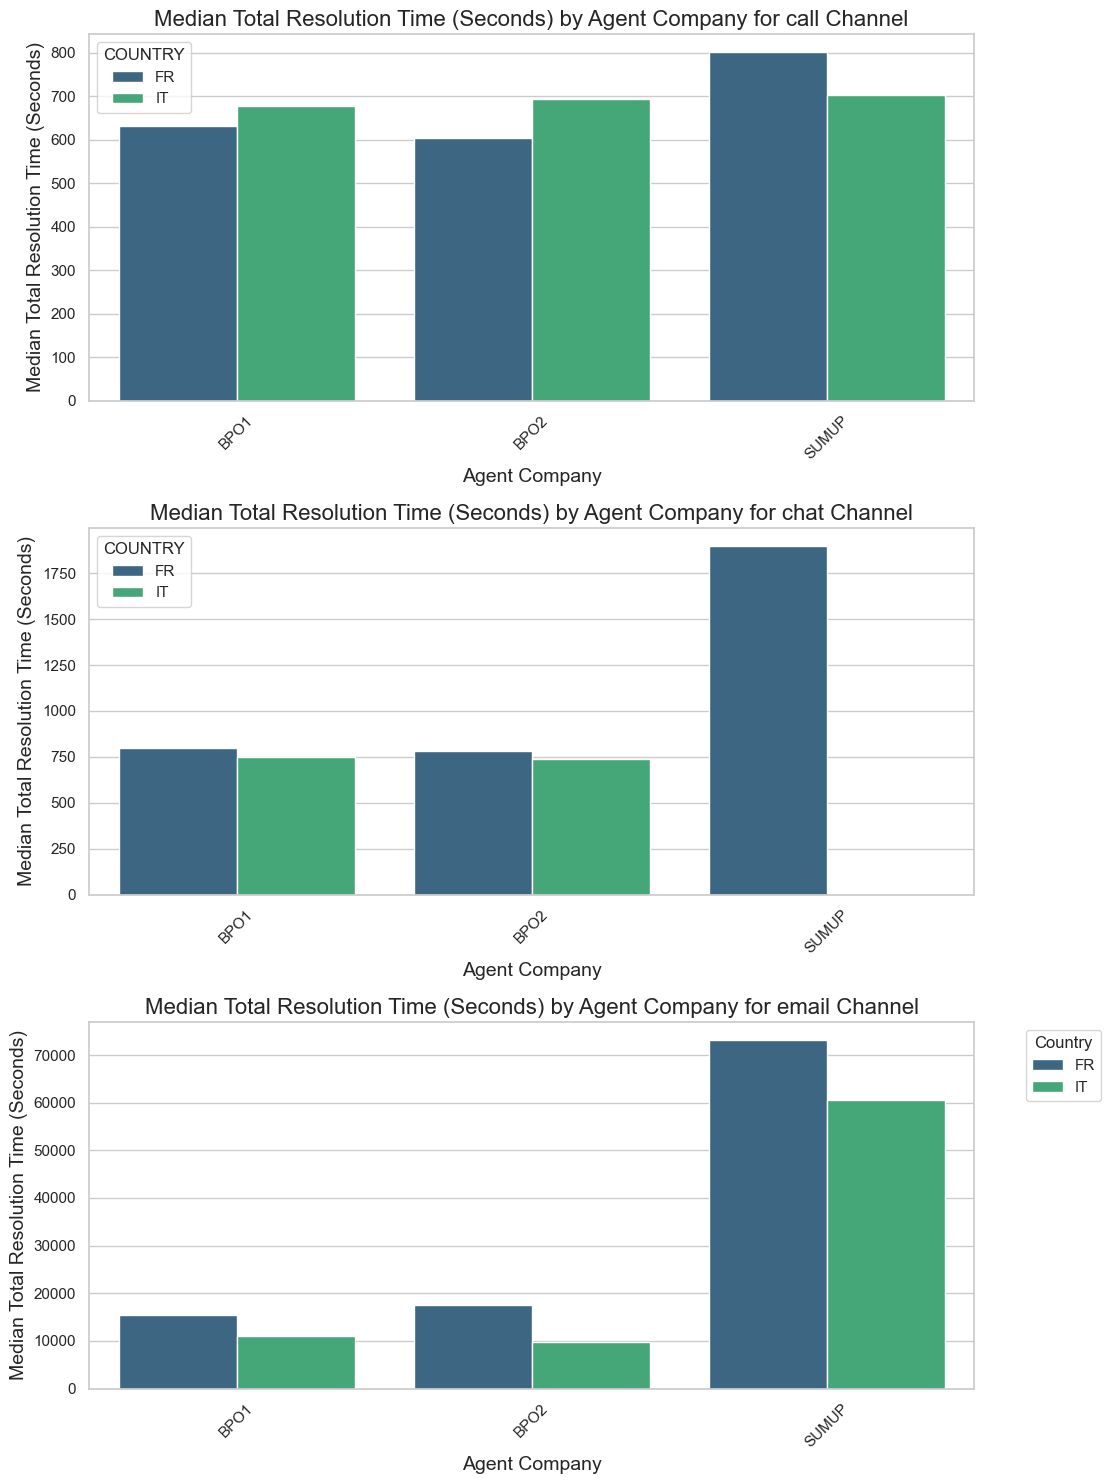

In [84]:
median_resolution_time = df.groupby(['AGENT_COMPANY', 'FINAL_CHANNEL', 'COUNTRY'])['TOTAL_RESOLUTION_TIME_SECONDS'].median().reset_index()

# Set up the plotting area
unique_channels = median_resolution_time['FINAL_CHANNEL'].unique()
num_channels = len(unique_channels)

# Create subplots for each channel
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels), sharex=False)

# Loop through each unique channel and create a separate bar plot
for ax, channel in zip(axes, unique_channels):
    # Filter data for the current channel
    channel_data = median_resolution_time[median_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create the bar plot for the current channel
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_SECONDS', hue='COUNTRY', ax=ax, palette='viridis')
    
    # Set titles and labels
    ax.set_title(f'Median Total Resolution Time (Seconds) by Agent Company for {channel} Channel', fontsize=16)
    ax.set_ylabel('Median Total Resolution Time (Seconds)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plots
plt.show()

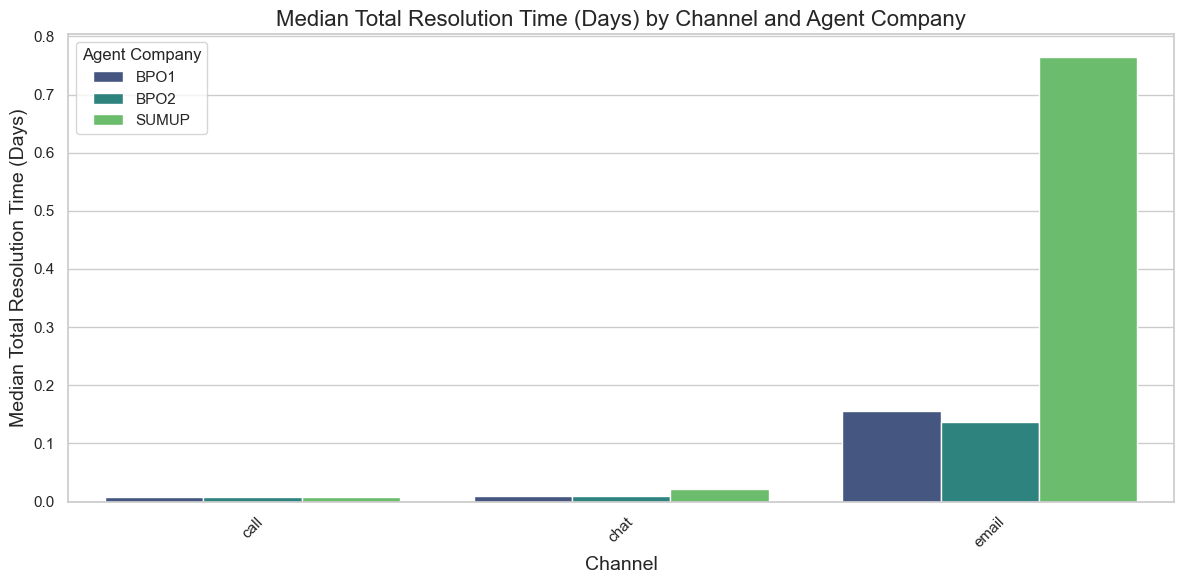

In [85]:
median_resolution = df.groupby(['FINAL_CHANNEL', 'AGENT_COMPANY'])['TOTAL_RESOLUTION_TIME_DAYS'].median().reset_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=median_resolution, x='FINAL_CHANNEL', y='TOTAL_RESOLUTION_TIME_DAYS', hue='AGENT_COMPANY', palette='viridis')

# Customize the plot
plt.title('Median Total Resolution Time (Days) by Channel and Agent Company', fontsize=16)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Median Total Resolution Time (Days)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Agent Company')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

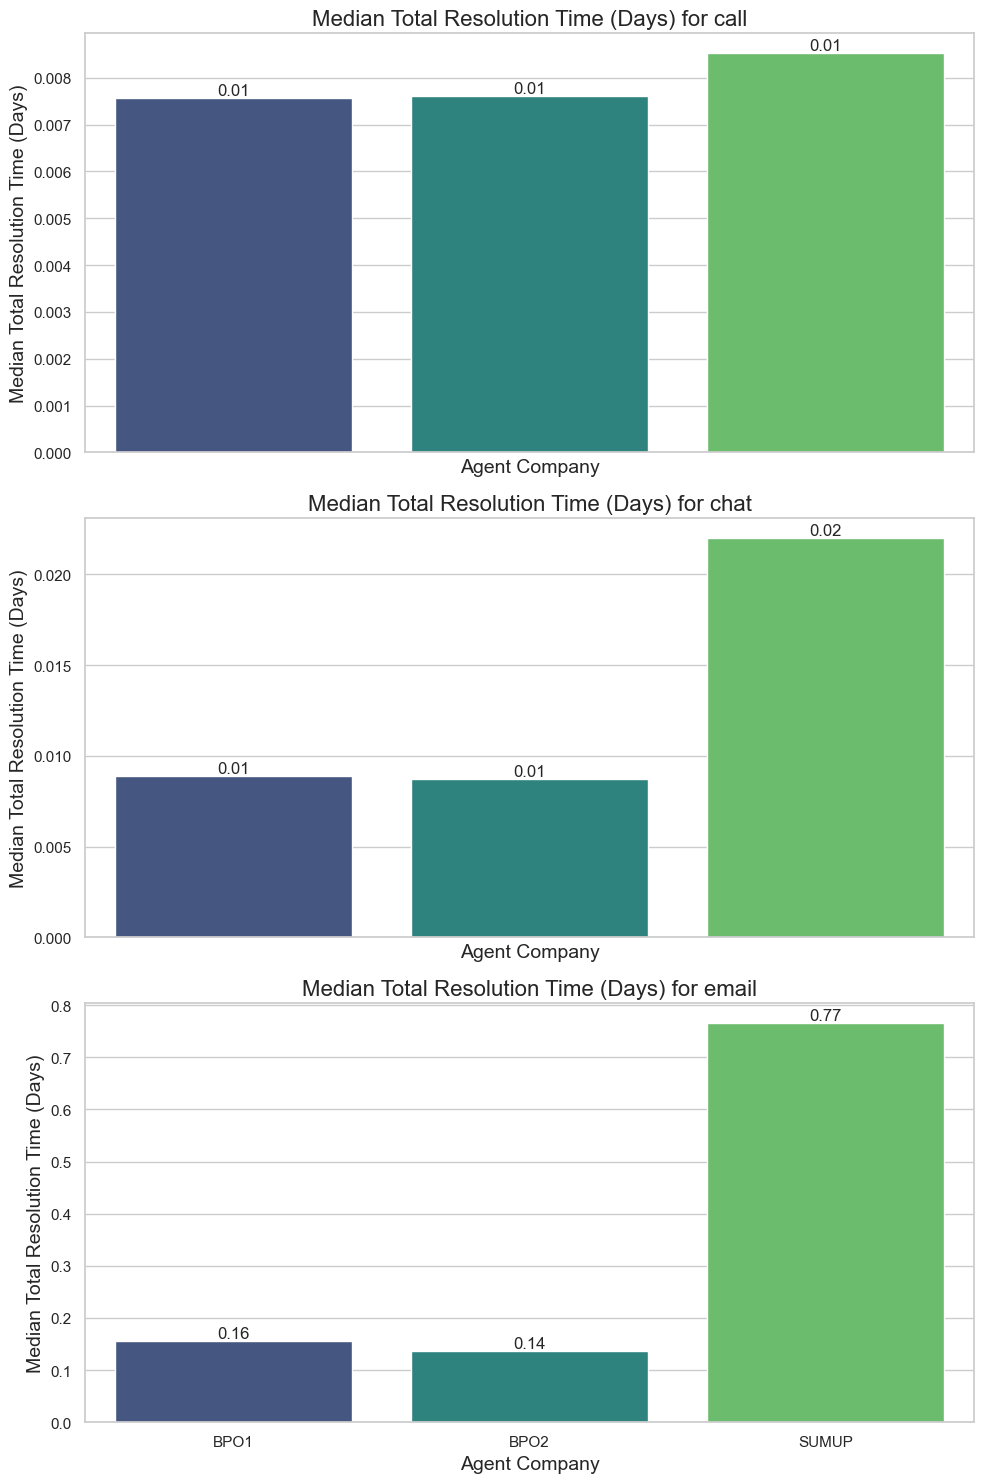

In [86]:
median_resolution_time = df.groupby(['FINAL_CHANNEL', 'AGENT_COMPANY'])['TOTAL_RESOLUTION_TIME_DAYS'].median().reset_index()
percentile_75_resolution_time = df.groupby(['FINAL_CHANNEL', 'AGENT_COMPANY'])['TOTAL_RESOLUTION_TIME_DAYS'].quantile(0.75).reset_index()
percentile_80_resolution_time = df.groupby(['FINAL_CHANNEL', 'AGENT_COMPANY'])['TOTAL_RESOLUTION_TIME_DAYS'].quantile(0.8).reset_index()
percentile_90_resolution_time = df.groupby(['FINAL_CHANNEL', 'AGENT_COMPANY'])['TOTAL_RESOLUTION_TIME_DAYS'].quantile(0.9).reset_index()


# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Get unique channels
channels = median_resolution_time['FINAL_CHANNEL'].unique()

# Create a figure with subplots for each channel
num_channels = len(channels)
fig, axes = plt.subplots(num_channels, 1, figsize=(10, num_channels * 5), sharex=True)

for ax, channel in zip(axes, channels):
    # Filter data for the specific channel
    channel_data = median_resolution_time[median_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create a bar plot for the median total resolution time
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', ax=ax, palette='viridis')
    
    # Set the title and labels
    ax.set_title(f'Median Total Resolution Time (Days) for {channel}', fontsize=16)
    ax.set_ylabel('Median Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)

# Adjust the layout
plt.tight_layout()
plt.show()


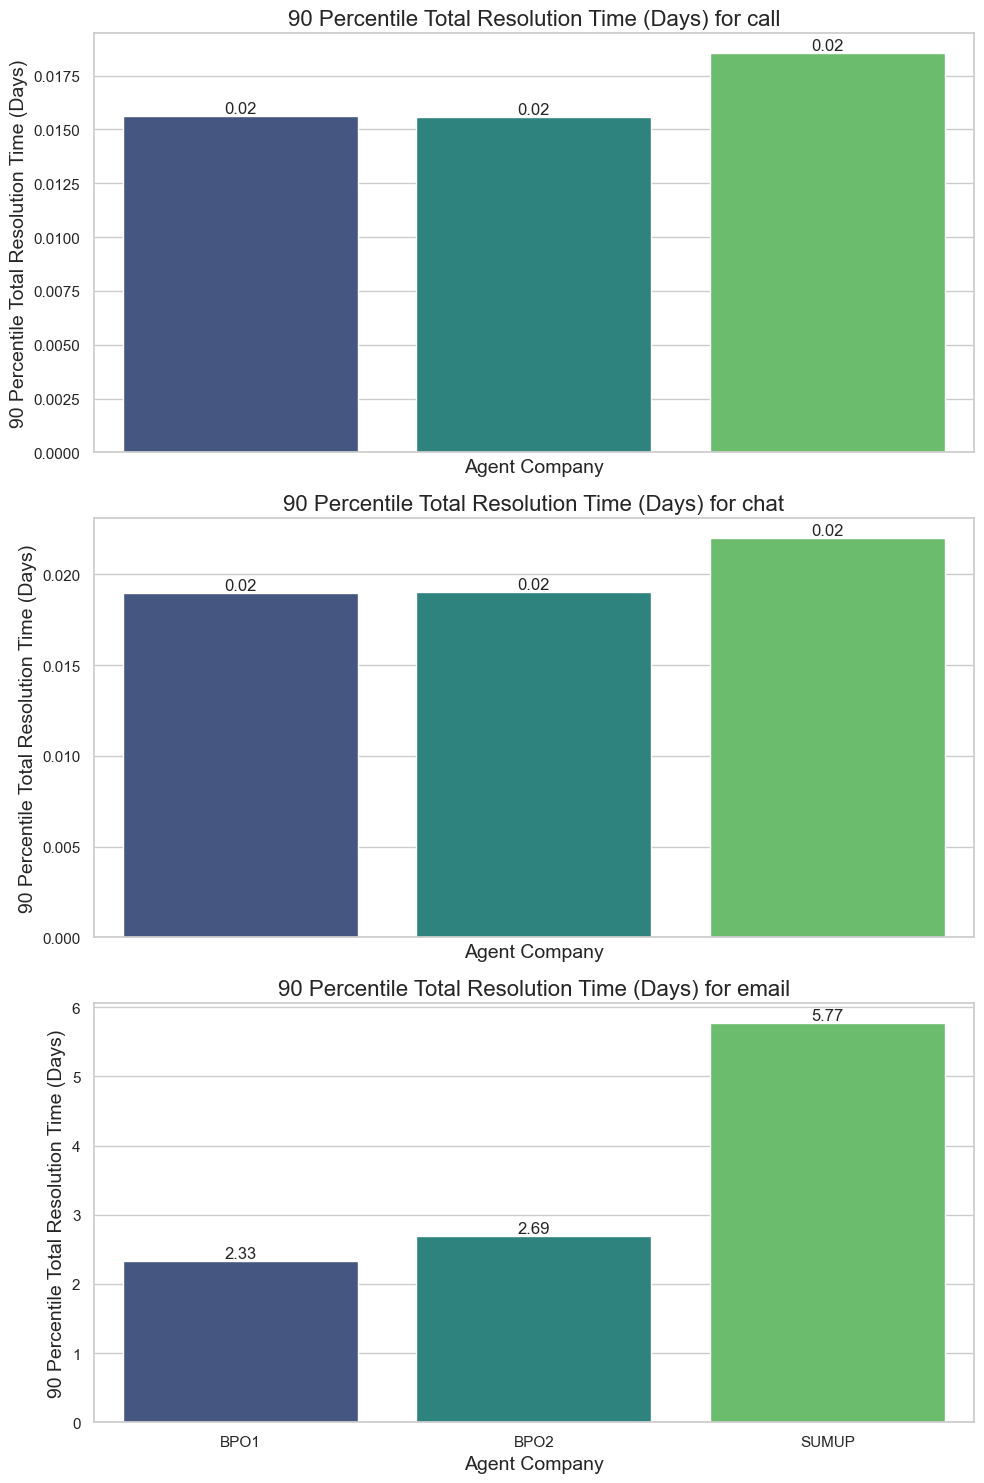

In [87]:
# Get unique channels
channels = percentile_90_resolution_time['FINAL_CHANNEL'].unique()

# Create a figure with subplots for each channel
num_channels = len(channels)
fig, axes = plt.subplots(num_channels, 1, figsize=(10, num_channels * 5), sharex=True)

for ax, channel in zip(axes, channels):
    # Filter data for the specific channel
    channel_data = percentile_90_resolution_time[percentile_90_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create a bar plot for the median total resolution time
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', ax=ax, palette='viridis')
    
    # Set the title and labels
    ax.set_title(f'90 Percentile Total Resolution Time (Days) for {channel}', fontsize=16)
    ax.set_ylabel('90 Percentile Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)

# Adjust the layout
plt.tight_layout()
plt.show()

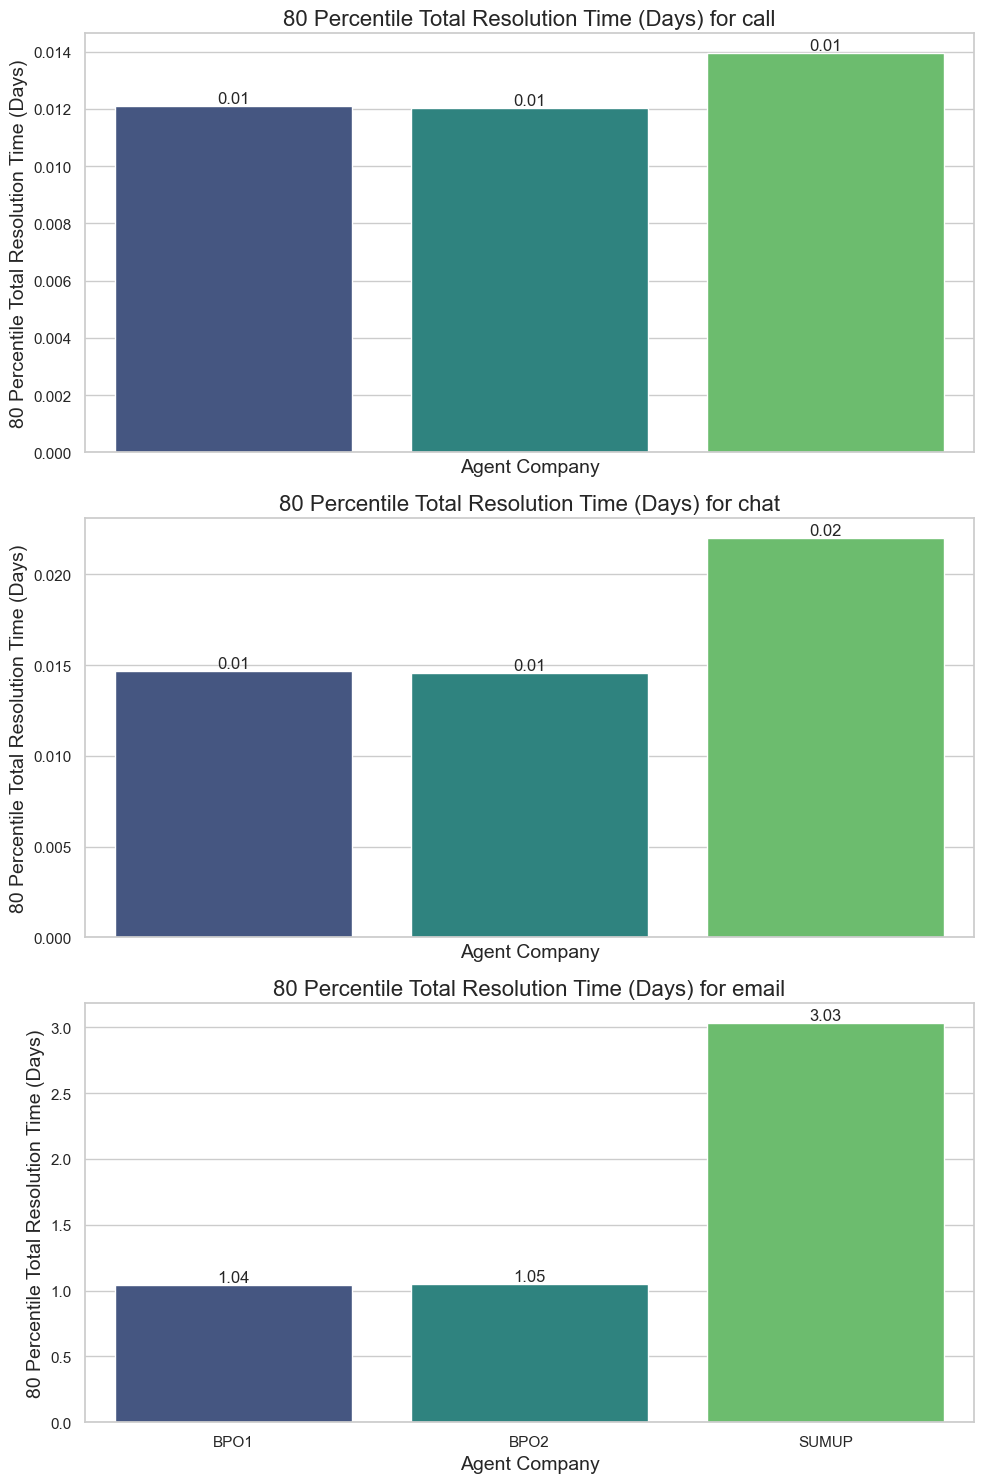

In [88]:
# Get unique channels
channels = percentile_80_resolution_time['FINAL_CHANNEL'].unique()

# Create a figure with subplots for each channel
num_channels = len(channels)
fig, axes = plt.subplots(num_channels, 1, figsize=(10, num_channels * 5), sharex=True)

for ax, channel in zip(axes, channels):
    # Filter data for the specific channel
    channel_data = percentile_80_resolution_time[percentile_80_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create a bar plot for the median total resolution time
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', ax=ax, palette='viridis')
    
    # Set the title and labels
    ax.set_title(f'80 Percentile Total Resolution Time (Days) for {channel}', fontsize=16)
    ax.set_ylabel('80 Percentile Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12)

# Adjust the layout
plt.tight_layout()
plt.show()

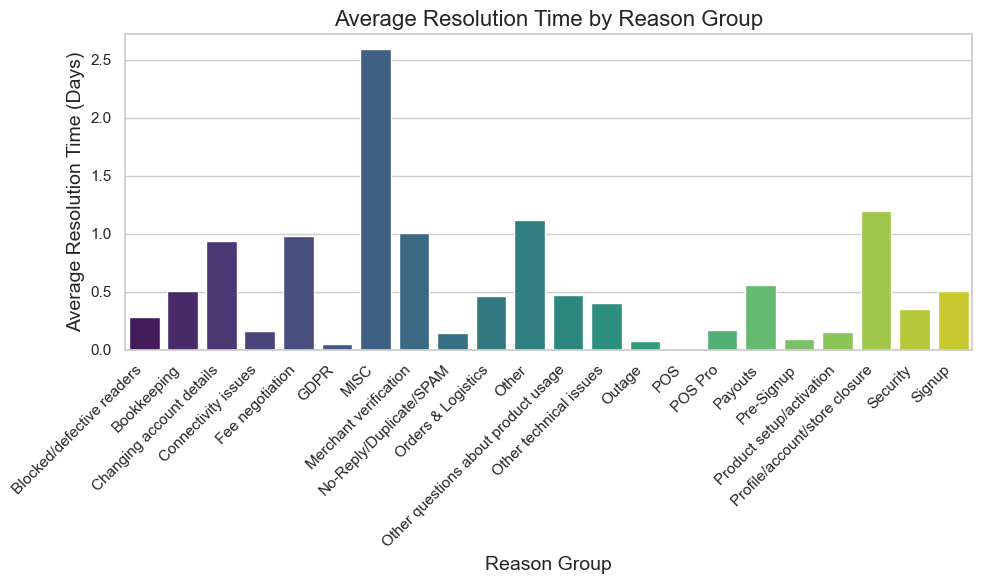

In [89]:
# Group by REASON_GROUP and calculate the average resolution time
avg_resolution_time = df.groupby('REASON_GROUP')['TOTAL_RESOLUTION_TIME_DAYS'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_resolution_time, x='REASON_GROUP', y='TOTAL_RESOLUTION_TIME_DAYS', palette='viridis')

# Customizing the chart
plt.title('Average Resolution Time by Reason Group', fontsize=16)
plt.xlabel('Reason Group', fontsize=14)
plt.ylabel('Average Resolution Time (Days)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

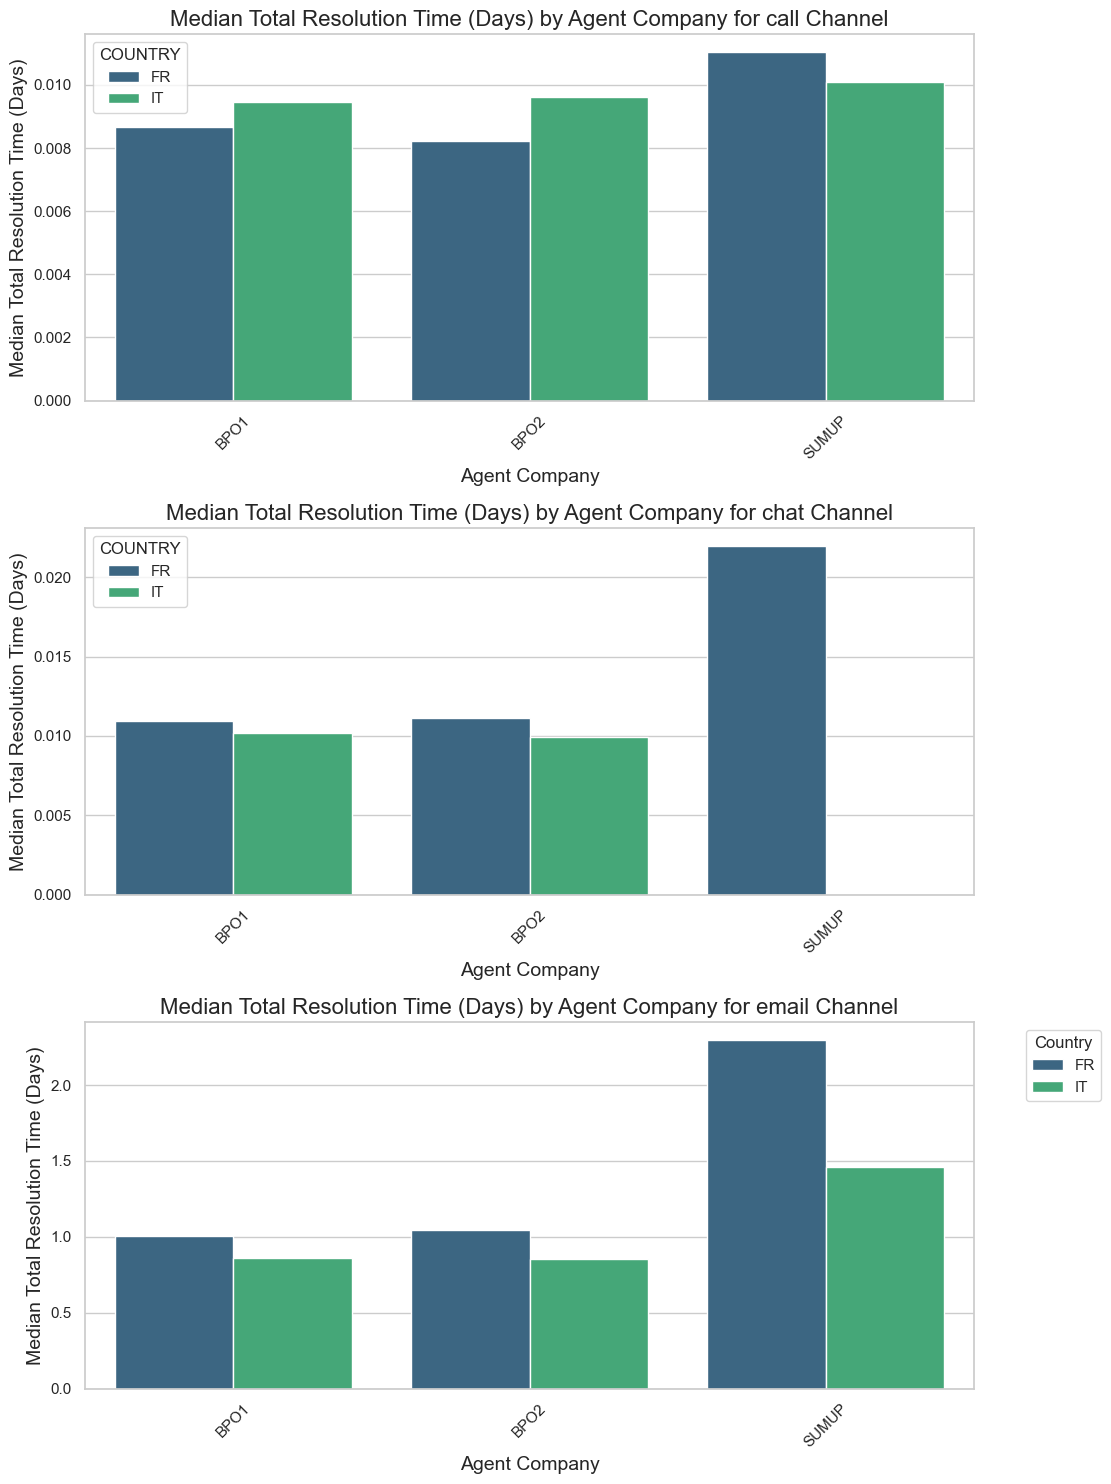

In [92]:
median_resolution_time = df.groupby(['AGENT_COMPANY', 'FINAL_CHANNEL', 'COUNTRY'])['TOTAL_RESOLUTION_TIME_DAYS'].mean().reset_index()

# Set up the plotting area
unique_channels = median_resolution_time['FINAL_CHANNEL'].unique()
num_channels = len(unique_channels)

# Create subplots for each channel
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels), sharex=False)

# Loop through each unique channel and create a separate bar plot
for ax, channel in zip(axes, unique_channels):
    # Filter data for the current channel
    channel_data = median_resolution_time[median_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create the bar plot for the current channel
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', hue='COUNTRY', ax=ax, palette='viridis')
    
    # Set titles and labels
    ax.set_title(f'Median Total Resolution Time (Days) by Agent Company for {channel} Channel', fontsize=16)
    ax.set_ylabel('Median Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plots
plt.show()

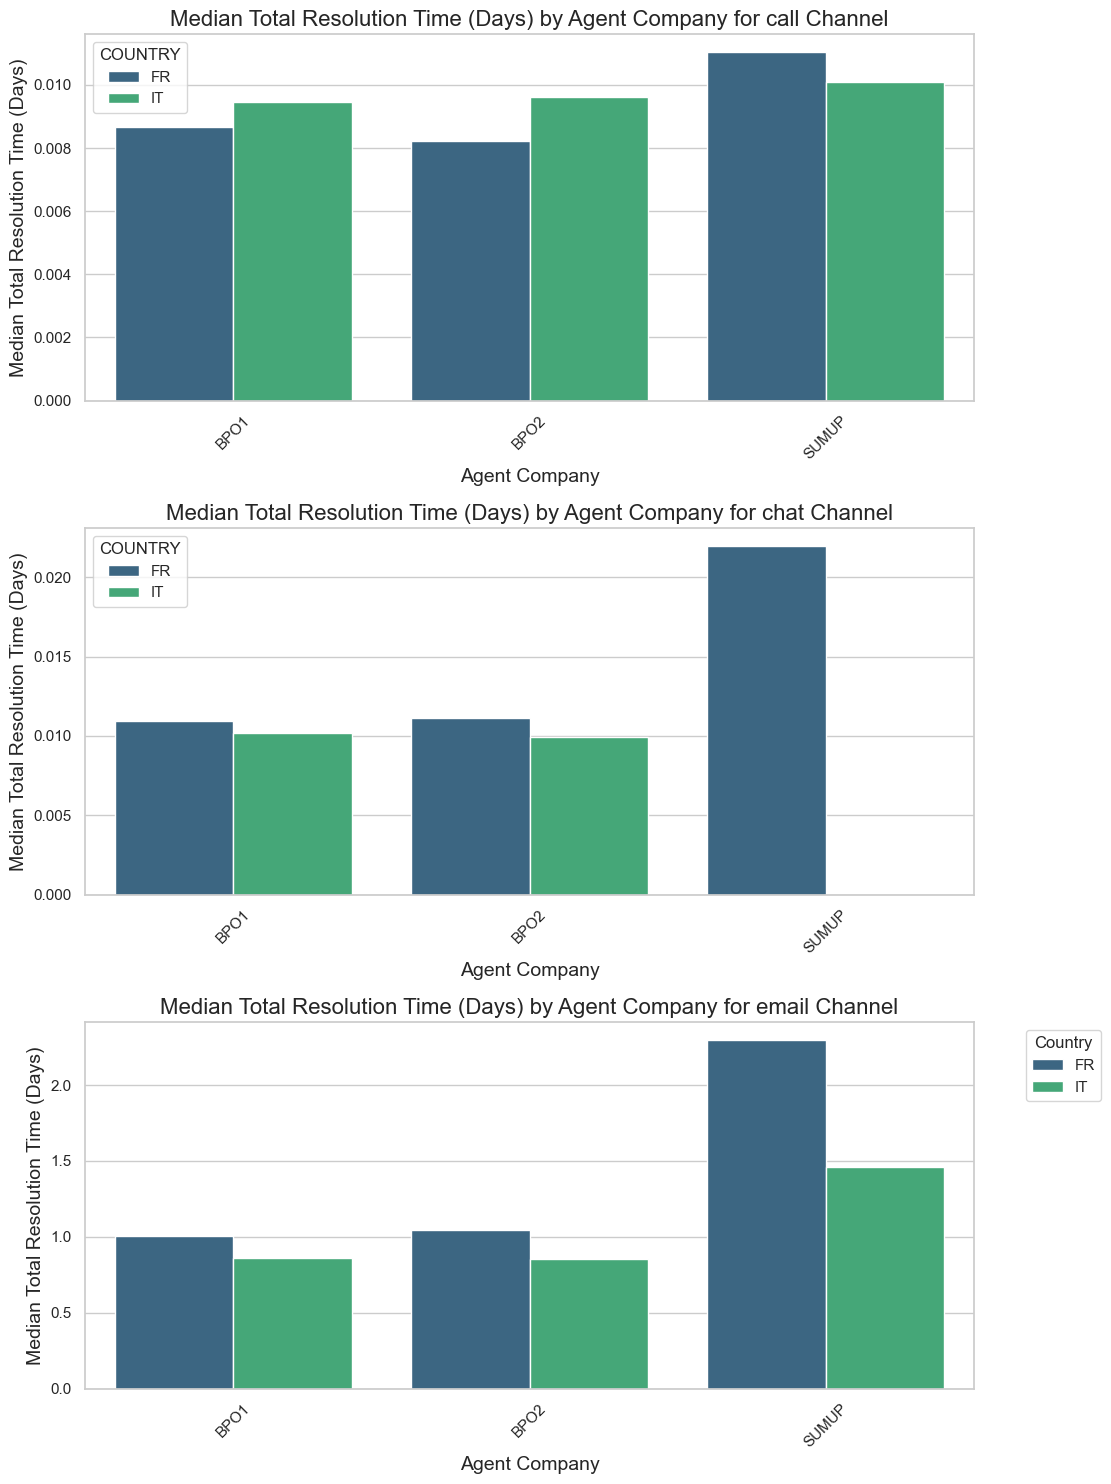

In [93]:
median_resolution_time = df.groupby(['AGENT_COMPANY', 'FINAL_CHANNEL', 'COUNTRY'])['TOTAL_RESOLUTION_TIME_DAYS'].mean().reset_index()

# Set up the plotting area
unique_channels = median_resolution_time['FINAL_CHANNEL'].unique()
num_channels = len(unique_channels)

# Create subplots for each channel
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 5 * num_channels), sharex=False)

# Loop through each unique channel and create a separate bar plot
for ax, channel in zip(axes, unique_channels):
    # Filter data for the current channel
    channel_data = median_resolution_time[median_resolution_time['FINAL_CHANNEL'] == channel]
    
    # Create the bar plot for the current channel
    sns.barplot(data=channel_data, x='AGENT_COMPANY', y='TOTAL_RESOLUTION_TIME_DAYS', hue='COUNTRY', ax=ax, palette='viridis')
    
    # Set titles and labels
    ax.set_title(f'Median Total Resolution Time (Days) by Agent Company for {channel} Channel', fontsize=16)
    ax.set_ylabel('Median Total Resolution Time (Days)', fontsize=14)
    ax.set_xlabel('Agent Company', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plots
plt.show()

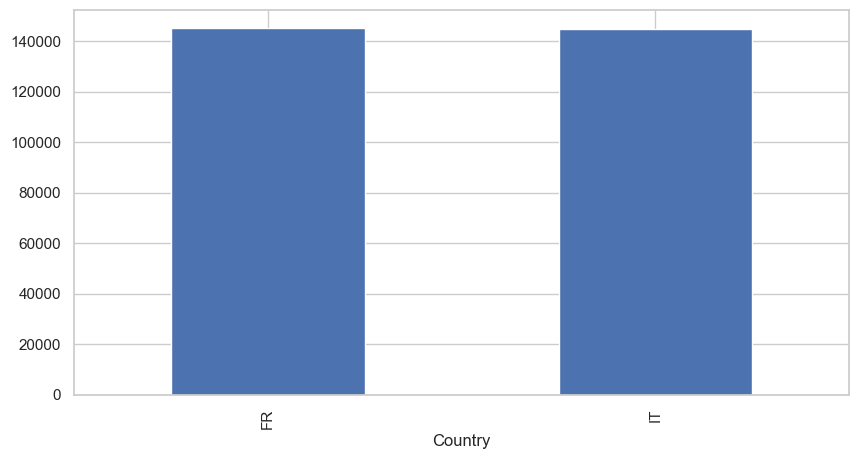

In [95]:
df.COUNTRY.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('Country');

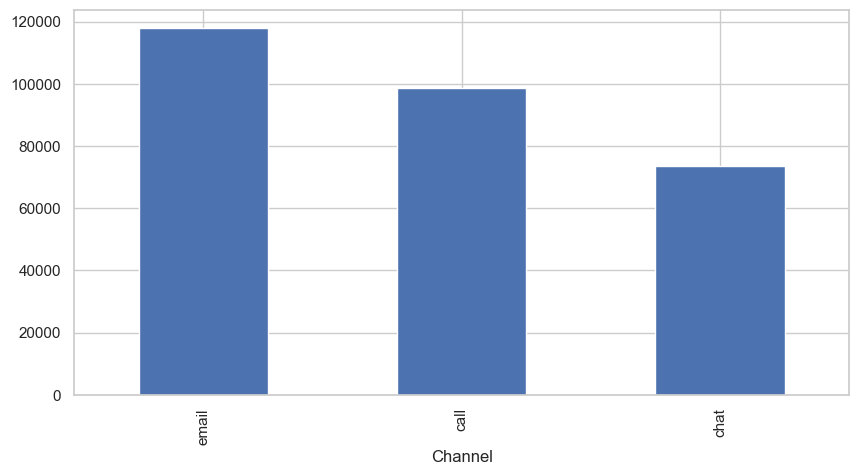

In [96]:
df.FINAL_CHANNEL.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('Channel');

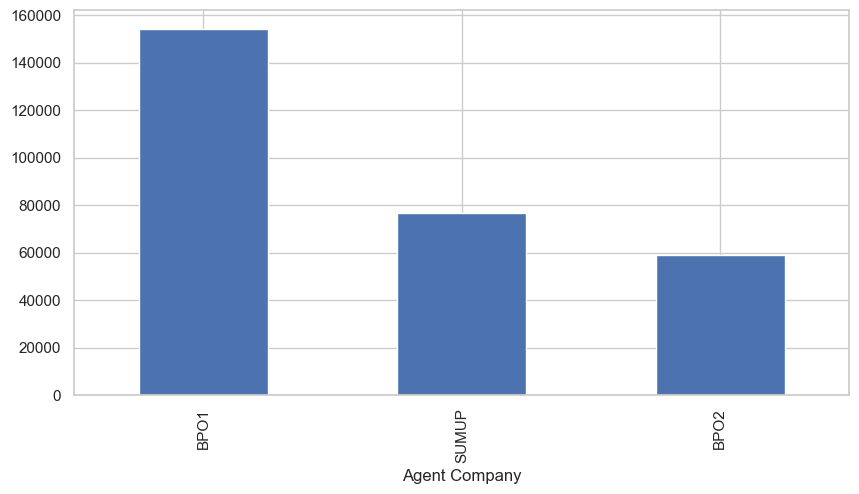

In [97]:
df.AGENT_COMPANY.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('Agent Company');

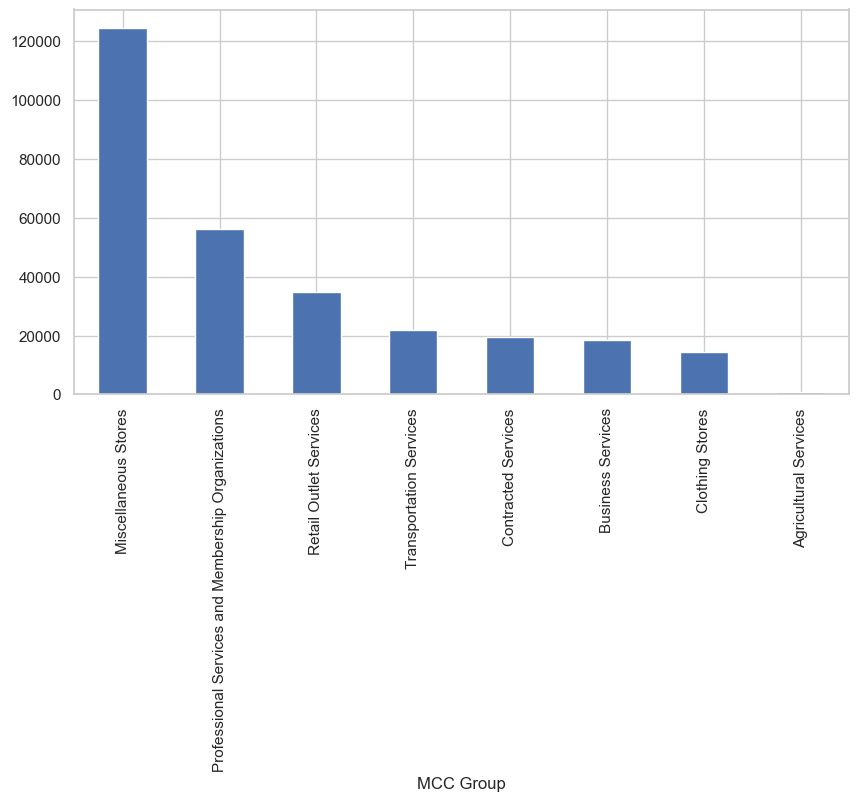

In [98]:
df.MCC_GROUP.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
matplotlib.pyplot.xlabel('MCC Group');

<Axes: xlabel='AGENT_COMPANY'>

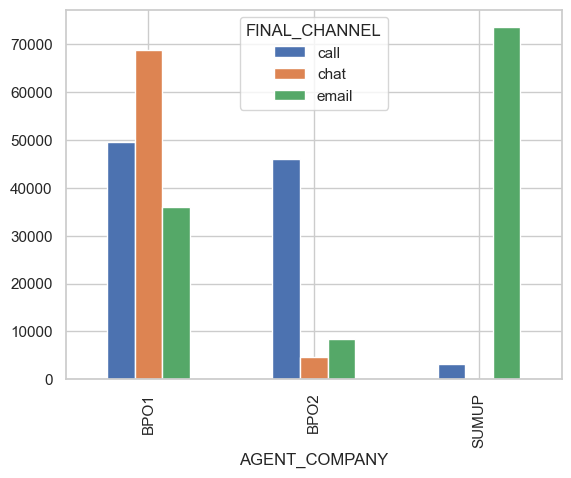

In [99]:


count_df = df.groupby(['AGENT_COMPANY', 'FINAL_CHANNEL']).size().reset_index(name='Count')
pivot_df = count_df.pivot(index='AGENT_COMPANY', columns='FINAL_CHANNEL', values='Count').fillna(0)
pivot_df.plot(kind='bar', stacked=False)


<Axes: xlabel='AGENT_COMPANY'>

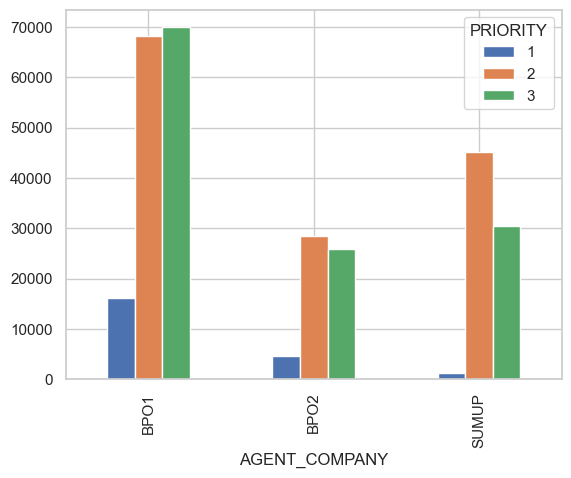

In [100]:

count_df = df.groupby(['AGENT_COMPANY', 'PRIORITY']).size().reset_index(name='Count')
pivot_df = count_df.pivot(index='AGENT_COMPANY', columns='PRIORITY', values='Count').fillna(0)
pivot_df.plot(kind='bar', stacked=False)